In [ ]:
import sys
print(sys.executable)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [ ]:
# from pygam import GAM, s

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

In [ ]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning

In [ ]:
import scipy
import sklearn

In [ ]:
print(scipy.__version__)
print(sklearn.__version__)

Data Importing & Cleaning

In [ ]:
data = pd.read_csv('VIX_data.csv')

In [ ]:
data.head()

In [ ]:
data.shape

In [ ]:
data.isnull().sum()

In [ ]:
(data== '').sum()

In [ ]:
total_check = data.isnull().sum() + (data== '').sum()

In [ ]:
has_missing_data = total_check.sum() >0
print(has_missing_data)

In [ ]:
data.index = pd.to_datetime(data['Date'])

In [ ]:
numeric_columns = data.select_dtypes(include=[np.number]).columns
column_means = data[numeric_columns].mean()

data_filled = data.copy()
data_filled[numeric_columns].fillna(column_means)

In [ ]:
data_filled.head()

In [ ]:
data_filled.shape

In [ ]:
VIX_data = data_filled['VIX']

In [ ]:
VIX_data.describe()

In [ ]:
VIX_data.head()

In [ ]:
data_interim = data_filled.reset_index(drop=True)
data_interim.set_index('Date', inplace=True)

data_interim.index = pd.to_datetime(data_interim.index)

In [ ]:
data_interim.head()

In [ ]:
t = data_interim.isnull().sum()
t.isnull().sum()

In [ ]:
Features = data_interim.drop('VIX', axis=1)

In [ ]:
Features.head()

In [ ]:
Features.shape

In [ ]:
Features.columns

In [ ]:
Features_clean = Features[['Unemployment Rate', 'CPI', 'Three Month T Bill Rate', 'Six Month T Bill Rate', 
                           '10-Year Treasury Constant Maturity Rate', 'Fed Rate', 'BBB Rate', 'SP500 Index', 
                           'SP500 Volume', 'NASDAQ Adj Close','NASDAQ Volume','DJI Adj Close','DJI Volume', 
                           'RUSSELL2000 Adj Close','RUSSELL2000 Volume','FTSE Adj Close','FTSE Volume','NIKKEI Adj Close',
                           'NIKKEI Volume','GDP', 'Initial Claims', 'JPY/USD Spot Rate', 'Spot Crude Oil Price',
                           'GOLD Adj Close','GOLD Volume', 'USD INDEX Adj Close']]

In [ ]:
Features_clean.head()

In [ ]:
Features_clean.shape

In [ ]:
Features_clean.isnull().sum()

In [ ]:
if isinstance(VIX_data, pd.Series):
    VIX = VIX_data.to_frame(name='VIX')


In [ ]:
isinstance(Features_clean, pd.DataFrame)

In [ ]:
VIX.head()

In [ ]:
data_clean = pd.concat([VIX, Features_clean], axis=1, join='inner')

In [ ]:
data_clean.shape

In [ ]:
data_clean.head()

In [ ]:
data_clean.isnull().sum()

In [ ]:
# plt.style.use('seaborn')

n_cols = 3
n_rows = (len(data_clean.columns)-1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
# fig.suptitle('Histograms of all Features', fontsize=16)

axes = axes.flatten()

for i, column in enumerate(data_clean.columns):
    sns.histplot(data=data_clean, x=column, kde=True, bins='auto', ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
n_cols = 3
n_rows = (len(data_clean.columns)-1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
# fig.suptitle('All Features', fontsize=16)

axes = axes.flatten()

for i, column in enumerate(data_clean.columns):
    sns.lineplot(data=data_clean, x=data_clean.index, y=column, ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
#Rolling statistics

def calculate_rolling_stats(df, window):
    rolling_mean = df.rolling(window=window).mean()
    rolling_std = df.rolling(window=window).std()
    return rolling_mean, rolling_std

In [ ]:

window_size = 6

rolling_mean, rolling_std = calculate_rolling_stats(data_clean, window=window_size)

In [ ]:

n_cols = 3
n_rows = (len(data_clean.columns)-1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axes = axes.flatten()

for i, column in enumerate(data_clean.columns):
    sns.lineplot(data=data_clean, x=data_clean.index, y=column, label='Original', ax=axes[i])
    sns.lineplot(data=rolling_mean, x=rolling_mean.index, y=rolling_mean[column], color='black', label='Rolling Mean', ax=axes[i])
    sns.lineplot(data=rolling_std, x=rolling_std.index, y=rolling_std[column], color='orange', label='Rolling Std', ax=axes[i])
    axes[i].legend(loc='best')
    axes[i].set_title(column)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
#Decompose

def decompose_and_plot(series, column, period):
    decomposition = seasonal_decompose(series, model='additive', period=period)

    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 3)
    
    fig.suptitle(column, fontsize=20)
    

    #Plot original data
    ax_original = fig.add_subplot(gs[0, :])
    ax_original.plot(series)
    ax_original.set_title('Original')
    ax_original.set_xlabel('')

    #Plot trend
    ax_trend = fig.add_subplot(gs[1, 0])
    ax_trend.plot(decomposition.trend)
    ax_trend.set_title('Trend')

    #Plot seasonal
    ax_seasonal = fig.add_subplot(gs[1, 1])
    ax_seasonal.plot(decomposition.seasonal)
    ax_seasonal.set_title('Seasonal')

    #Plot residual
    ax_residual = fig.add_subplot(gs[1, 2])
    ax_residual.plot(decomposition.resid)
    ax_residual.set_title('Residual')

    plt.tight_layout()
    plt.show()



In [ ]:
period = 12

for column in data_clean.columns:
    decompose_and_plot(data_clean[column], column, period)

In [ ]:
# # #Generalized Additive Models 
# X = Features_clean['BBB Rate'].values.reshape(-1, 1)
# y = VIX

# gam = GAM(s(0, n_splines=10))
# gam.fit(X, y)

# XX = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
# gam_predictions = gam.predict(XX)

# plt.figure(figsize=(10,6))
# plt.scatter(X, y, alpha=0.1)
# plt.plot(XX, gam_predictions, color='r', linewidth=2)
# plt.title('GAM: VIX Vs BBB Rate')
# plt.xlabel('BBB Rate')
# plt.ylabel('VIX')
# plt.show()

# print(gam.summary())



In [ ]:
#Feature Selection
X = data_clean.iloc[:, 1:] #Features
y = data_clean.iloc[:, 0] #VIX

tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
selected_features_list = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_scaled, y_train)

selector = SelectFromModel(lasso, prefit=True)

selected_feature_indices = selector.get_support(indices=True)

selected_features =  X.columns[selected_feature_indices]
selected_features_list.append(selected_features)

#Transform data to use only selected features
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

#Fit new Lasso model on selected features
lasso_selected = Lasso(alpha=0.1, random_state=42)
lasso_selected.fit(X_train_selected, y_train)

y_pred = lasso_selected.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
mse_scores.append(mse)

#Print average MSE
print(f'Average MSE across folds: {np.mean(mse_scores)}')

#Count faeture occurences across all folds
feature_counts = {}
for features in selected_features_list:
    for feature in features:
        if feature in feature_counts:
            feature_counts[feature] += 1
        else:
            feature_counts[feature] = 1

#Print faetures selected in all folds
print('\nFeatures selected in all folds:')
for feature, count in feature_counts.items():
    if count == len(selected_features_list):
        print(feature)

#Print features selected in majority of folds
print('\nFeatures selected in majority of folds:')
for feature, count in feature_counts.items():
    if count > len(selected_features_list) / 2:
        print(f'{feature}: {count} / {len(selected_features_list)} folds')


In [ ]:
#Scaling the data for the model
scaler = StandardScaler()

scaled_df = pd.DataFrame(scaler.fit_transform(data_clean), columns=data_clean.columns)

In [ ]:
scaled_df.describe()

In [ ]:
#ACF and PACF of original VIX data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

sm.graphics.tsa.plot_acf(data_clean['VIX'], lags=50, ax=ax1)
ax1.set_title('Autocorrelation Function')

sm.graphics.tsa.plot_pacf(data_clean['VIX'], lags=50, ax=ax2)
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [ ]:
#Difference the Data

differenced_data = data_clean.diff() #First order differencing

differenced_data.iloc[0] = 0 #First entry of differenced data is typically NaN because there is no previous value to subtract from the first observation

num_columns = len(differenced_data.columns)

nrows = (num_columns + 1) // 2


plt.figure(figsize=(15, 5 * nrows))

for i, column in enumerate(differenced_data.columns):
    plt.subplot(nrows, 2, i + 1)
    plt.plot(differenced_data.index, differenced_data[column])
    plt.title(f'Differenced {column}')
    plt.xlabel('Date')
    plt.ylabel('Difference')
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [ ]:
#Check for NaN or infinite values

missing_values = differenced_data.isnull().sum() + (differenced_data == float('inf')).sum() + (differenced_data == float('-inf')).sum()
print(f'Number of missing or ifinite values: {missing_values}')

In [ ]:
#ADF / Augmented Dickey Fuller Test
def adfuller_test(series):
    adf_result = adfuller(series, autolag='AIC')
    return{
        'ADF Statistic': adf_result[0], 
        'p-value': adf_result[1],
        'Lags used': adf_result[2],
        'Observations used': adf_result[3],
        'Critical Values': adf_result[4]
        }

In [ ]:
adf_results = differenced_data.apply(adfuller_test, axis=0)

In [ ]:
adf_results.describe()

In [ ]:
print(adf_results)

In [ ]:
adf_results['VIX']

In [ ]:
#KPSS / Kwiatkowski-Phillips-Schmidt-Shin Test
def kpss_test(series, **kw):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=InterpolationWarning)
    
        statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    return{
        'KPSS Statistic': statistic,
        'p_value': p_value,
        'num lags': n_lags,
        'Critical Values': critical_values
    }

In [ ]:
kpss_results = differenced_data.apply(kpss_test, axis=0)

In [ ]:
print(kpss_results.iloc[:1])

In [ ]:
#Philips-Perron Test
pp_test = differenced_data.apply(PhillipsPerron)

In [ ]:
pp_test[2]

In [ ]:
#ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

sm.graphics.tsa.plot_acf(differenced_data['VIX'], lags=50, ax=ax1)
ax1.set_title('Autocorrelation Function')

sm.graphics.tsa.plot_pacf(differenced_data['VIX'], lags=50, ax=ax2)
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


In [ ]:
log_data = np.log1p(data_clean)

In [ ]:
#Determine p, d, q values
def determine_p_d_q_values(timeseries, lags):
    #Calculate autocorrelation and partial autocorrelation values
    acf_values = acf(timeseries, nlags=lags)
    pacf_values = pacf(timeseries, nlags=lags)

    #Determine value of p
    p = 0
    for i in range(1, len(acf_values)):
        if abs(acf_values[i]) > 1.96 / len(timeseries) ** 0.5: #threshold for statistical significance of autocorrelation at 95% confidence level
                                                                #Crtical value for 95% confidence level in standard normal distribution = 1.96 
                                                                #Standard error of autocorrelation = 1.95*(1/sqrt(N)) for large samples
            p = i
            break

    #Determine value of d
    d = 0
    p_value_adf = adfuller(timeseries)[1]
    while p_value_adf > 0.05:
        timeseries = np.diff(timeseries)
        d += 1
        p_value_adf = adfuller(timeseries)[1]

    #Determine value of q
    q = 0
    for i in range(1, len(pacf_values)):
        if abs(pacf_values[i]) > 1.96 / len(timeseries) ** 0.5:
            q = i
            break

    return p, d, q

In [ ]:
lags = 50
timeseries = log_data.iloc[:, 0]
exogenous_variables = log_data.iloc[:, 1:]

In [ ]:
#Manual determination of p, d, q
p, d, q = determine_p_d_q_values(timeseries, lags)
print(f'p: {p}, d: {d}, q: {q}')

In [ ]:
#Determine p,d,q using auto_arima
auto_arima_model = auto_arima(timeseries, 
                              exogenous=exogenous_variables,
                              start_p=1, start_q=1, 
                              test='adf',
                              max_p=5, max_q=5,
                              m=12, #VIX data = monthly data with yearly seasonality
                              d=None,
                              seasonal=True,
                              start_P=1, start_Q=1,
                              D=None,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True
                              )

print(auto_arima_model.order)
print(auto_arima_model.seasonal_order)

In [ ]:
p, d, q =auto_arima_model.order
P, D, Q, m = auto_arima_model.seasonal_order

In [ ]:
print(f'p: {p}, d: {d}, q: {q}')
print(f'\nP: {P}, D: {D}, Q: {Q}')

In [ ]:
#Train and Test Data
train_size=int(len(log_data)*0.8)
train_data = log_data[:train_size]
test_data = log_data[train_size:]

train_target = train_data.iloc[:, 0] #VIX
test_target = test_data.iloc[:, 0]
train_exog = train_data.iloc[:, 1:]
test_exog = test_data.iloc[:, 1:]

In [ ]:
#ARIMA model
arima_model = ARIMA(train_target, order=(p, d, q))
arima_results = arima_model.fit()

log_arima_forecast = arima_results.forecast(steps=len(test_target))

arima_forecast = np.exp(log_arima_forecast) #Back-transform to ensure non-negativity
arima_forecast = np.maximum(arima_forecast, 0)

In [ ]:
arima_results.summary()

In [ ]:
arima_results.plot_diagnostics(figsize=(16,8))
plt.show()

In [ ]:
#ARIMAX model
arimax_model = SARIMAX(train_target, exog=train_exog, order=(p, d, q))
arimax_results = arimax_model.fit()

log_arimax_forecast = arimax_results.forecast(steps=len(test_target), exog=test_exog)

arimax_forecast = np.exp(log_arimax_forecast)
arimax_forecast = np.maximum(arimax_forecast, 0)

In [ ]:
arimax_results.summary()

In [ ]:
arimax_results.plot_diagnostics(figsize=(16,8))
plt.show()

In [ ]:
#SARIMAX model
P=1
D=1
Q=1 #Can change later
sarimax_model = SARIMAX(train_target,
                        exog=train_exog,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, m)
                        )

sarimax_results = sarimax_model.fit()

log_sarimax_forecast = sarimax_results.forecast(steps=len(test_target), exog=test_exog)

sarimax_forecast = np.exp(log_sarimax_forecast)
sarimax_forecast = np.maximum(sarimax_forecast, 0)

In [ ]:
sarimax_results.summary()

In [ ]:
sarimax_results.plot_diagnostics(figsize=(16,8))
plt.show()

In [ ]:
#Error Functions: MSE, MAPE, Direction Accuracy, RMSE, R2-score
def calculate_metrics(model_name, y_true, y_pred):
    #Convert inputs to numpy arrays of floats
    y_true = np.array(y_true).astype(float)
    y_pred = np.array(y_pred).astype(float)

    #Add small epsilon to avoid division by zero in MAPE calculation
    epsilon = 1e-10
    
    #MSE (Mean Squared Error)
    mse = mean_squared_error(y_true, y_pred)

    #Mean Absolute Percentage Error
    mape = mean_absolute_percentage_error(y_true, y_pred)

    #Direction Accurancy
    direction_true = np.sign(np.diff(y_true))
    direction_pred = np.sign(np.diff(y_pred))
    direction_accuracy = np.mean(direction_true == direction_pred) * 100

    #RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    #R2-score
    r2 = r2_score(y_true, y_pred)

    return { 
        'Model' : model_name,
        'MSE' : mse,
        'MAPE' : mape,
        'Direction Accuracy' : direction_accuracy,
        'RMSE' : rmse,
        'R2-score' : r2
    }

In [ ]:
arima_metrics = calculate_metrics('ARIMA', np.exp(test_target), arima_forecast)
arimax_metrics = calculate_metrics('ARIMAX', np.exp(test_target), arimax_forecast)
sarimax_metrics = calculate_metrics('SARIMAX', np.exp(test_target), sarimax_forecast)

for metrics in [arima_metrics, arimax_metrics, sarimax_metrics]:
    print(f'\n Metrics for {metrics['Model']}:')
    for key, value in metrics.items():
        if key != 'Model':
            print(f'{key}: {value:.2f}')

In [ ]:
#Plot Error Functions
models = ['ARIMA', 'ARIMAX', 'SARIMAX']

metrics_list = [arima_metrics, arimax_metrics, sarimax_metrics]

aic_values = {
    'ARIMA' : arima_results.aic,
    'ARIMAX' : arimax_results.aic,
    'SARIMAX' : sarimax_results.aic
}

aic = [aic_values[model] for model in models]

#Create dictionary to store all metrics
all_metrics = {
    'MSE' : {},
    'MAPE' : {},
    'Direction Accuracy' : {},
    'RMSE' : {},
    'R2-score' : {},
    'AIC' : aic_values
}

#Populate the all_metrics dictionary
for metrics in metrics_list:
    model = metrics['Model']
    for key, value in metrics.items():
        if key != 'Model':
            all_metrics[key][model] = value

#Create subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Model Comparison Metrics', fontsize=16)

axs = axs.flatten()

# colors = ['deep', 'muted', 'pastel']

for i, (metric, values) in enumerate(all_metrics.items()):
    ax = axs[i]
    metric_values = [values.get(model, np.nan) for model in models]
    
    bars = ax.bar(models, metric_values)
    ax.set_ylabel(metric)
    ax.set_title(metric)

    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', 
                ha='center', va='bottom', rotation=0)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

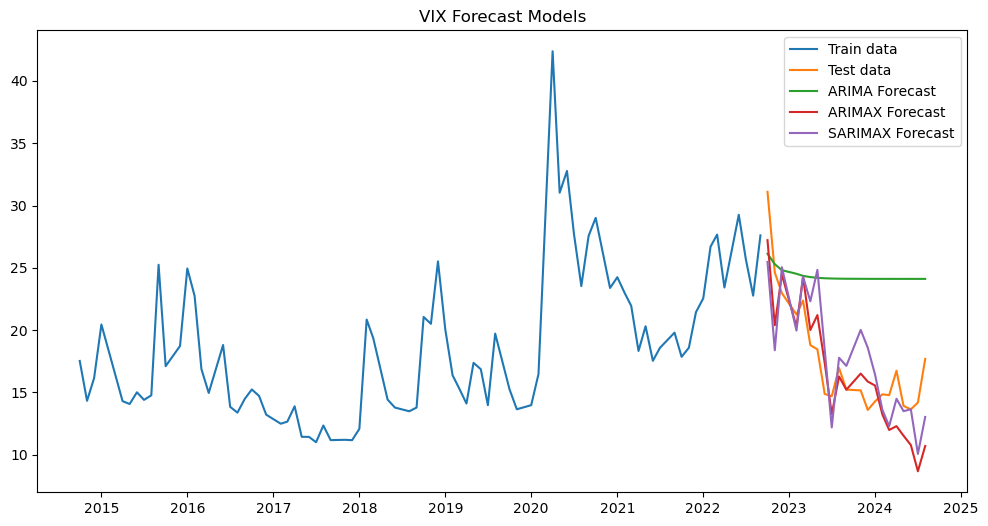

In [79]:
#Plot the model forecasts
plt.figure(figsize = (12, 6))
plt.plot(train_target.index, np.exp(train_target), label='Train data')
plt.plot(test_target.index, np.exp(test_target), label='Test data')
plt.plot(test_target.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test_target.index, arimax_forecast, label='ARIMAX Forecast')
plt.plot(test_target.index, sarimax_forecast, label='SARIMAX Forecast')

plt.legend(loc='best')
plt.title('VIX Forecast Models')
plt.show()
